https://en.wikipedia.org/wiki/Rank-maximal_allocation

In [1]:
!pip install scipy numpy
%config Completer.use_jedi = False

In [2]:
import numpy as np

In [3]:
import scipy.optimize

In [4]:
# Hungarian algorithm (Kuhn-Munkres) for solving the linear sum assignment
# problem. Taken from scikit-learn. Based on original code by Brian Clapper,
# adapted to NumPy by Gael Varoquaux.
# Further improvements by Ben Root, Vlad Niculae and Lars Buitinck.
#
# Copyright (c) 2008 Brian M. Clapper <bmc@clapper.org>, Gael Varoquaux
# Author: Brian M. Clapper, Gael Varoquaux
# License: 3-clause BSD

import numpy as np


def linear_sum_assignment(cost_matrix):
    """Solve the linear sum assignment problem.

    The linear sum assignment problem is also known as minimum weight matching
    in bipartite graphs. A problem instance is described by a matrix C, where
    each C[i,j] is the cost of matching vertex i of the first partite set
    (a "worker") and vertex j of the second set (a "job"). The goal is to find
    a complete assignment of workers to jobs of minimal cost.

    Formally, let X be a boolean matrix where :math:`X[i,j] = 1` iff row i is
    assigned to column j. Then the optimal assignment has cost

    .. math::
        \min \sum_i \sum_j C_{i,j} X_{i,j}

    s.t. each row is assignment to at most one column, and each column to at
    most one row.

    This function can also solve a generalization of the classic assignment
    problem where the cost matrix is rectangular. If it has more rows than
    columns, then not every row needs to be assigned to a column, and vice
    versa.

    The method used is the Hungarian algorithm, also known as the Munkres or
    Kuhn-Munkres algorithm.

    Parameters
    ----------
    cost_matrix : array
        The cost matrix of the bipartite graph.

    Returns
    -------
    row_ind, col_ind : array
        An array of row indices and one of corresponding column indices giving
        the optimal assignment. The cost of the assignment can be computed
        as ``cost_matrix[row_ind, col_ind].sum()``. The row indices will be
        sorted; in the case of a square cost matrix they will be equal to
        ``numpy.arange(cost_matrix.shape[0])``.

    Notes
    -----
    .. versionadded:: 0.17.0

    Examples
    --------
    >>> cost = np.array([[4, 1, 3], [2, 0, 5], [3, 2, 2]])
    >>> from scipy.optimize import linear_sum_assignment
    >>> row_ind, col_ind = linear_sum_assignment(cost)
    >>> col_ind
    array([1, 0, 2])
    >>> cost[row_ind, col_ind].sum()
    5

    References
    ----------
    1. http://csclab.murraystate.edu/bob.pilgrim/445/munkres.html

    2. Harold W. Kuhn. The Hungarian Method for the assignment problem.
       *Naval Research Logistics Quarterly*, 2:83-97, 1955.

    3. Harold W. Kuhn. Variants of the Hungarian method for assignment
       problems. *Naval Research Logistics Quarterly*, 3: 253-258, 1956.

    4. Munkres, J. Algorithms for the Assignment and Transportation Problems.
       *J. SIAM*, 5(1):32-38, March, 1957.

    5. https://en.wikipedia.org/wiki/Hungarian_algorithm
    """
    cost_matrix = np.asarray(cost_matrix)
    if len(cost_matrix.shape) != 2:
        raise ValueError("expected a matrix (2-d array), got a %r array"
                         % (cost_matrix.shape,))

    # The algorithm expects more columns than rows in the cost matrix.
    if cost_matrix.shape[1] < cost_matrix.shape[0]:
        cost_matrix = cost_matrix.T
        transposed = True
    else:
        transposed = False

    state = _Hungary(cost_matrix)

    # No need to bother with assignments if one of the dimensions
    # of the cost matrix is zero-length.
    step = None if 0 in cost_matrix.shape else _step1

    while step is not None:
        step = step(state)

    if transposed:
        marked = state.marked.T
    else:
        marked = state.marked
    return np.where(marked == 1)


class _Hungary(object):
    """State of the Hungarian algorithm.

    Parameters
    ----------
    cost_matrix : 2D matrix
        The cost matrix. Must have shape[1] >= shape[0].
    """

    def __init__(self, cost_matrix):
        self.C = cost_matrix.copy()

        n, m = self.C.shape
        self.row_uncovered = np.ones(n, dtype=bool)
        self.col_uncovered = np.ones(m, dtype=bool)
        self.Z0_r = 0
        self.Z0_c = 0
        self.path = np.zeros((n + m, 2), dtype=int)
        self.marked = np.zeros((n, m), dtype=int)

    def _clear_covers(self):
        """Clear all covered matrix cells"""
        self.row_uncovered[:] = True
        self.col_uncovered[:] = True


# Individual steps of the algorithm follow, as a state machine: they return
# the next step to be taken (function to be called), if any.

def _step1(state):
    """Steps 1 and 2 in the Wikipedia page."""

    # Step 1: For each row of the matrix, find the smallest element and
    # subtract it from every element in its row.
    state.C -= state.C.min(axis=1)[:, np.newaxis]
    # Step 2: Find a zero (Z) in the resulting matrix. If there is no
    # starred zero in its row or column, star Z. Repeat for each element
    # in the matrix.
    for i, j in zip(*np.where(state.C == 0)):
        if state.col_uncovered[j] and state.row_uncovered[i]:
            state.marked[i, j] = 1
            state.col_uncovered[j] = False
            state.row_uncovered[i] = False

    state._clear_covers()
    return _step3


def _step3(state):
    """
    Cover each column containing a starred zero. If n columns are covered,
    the starred zeros describe a complete set of unique assignments.
    In this case, Go to DONE, otherwise, Go to Step 4.
    """
    marked = (state.marked == 1)
    state.col_uncovered[np.any(marked, axis=0)] = False

    if marked.sum() < state.C.shape[0]:
        return _step4


def _step4(state):
    """
    Find a noncovered zero and prime it. If there is no starred zero
    in the row containing this primed zero, Go to Step 5. Otherwise,
    cover this row and uncover the column containing the starred
    zero. Continue in this manner until there are no uncovered zeros
    left. Save the smallest uncovered value and Go to Step 6.
    """
    # We convert to int as numpy operations are faster on int
    C = (state.C == 0).astype(int)
    covered_C = C * state.row_uncovered[:, np.newaxis]
    covered_C *= np.asarray(state.col_uncovered, dtype=int)
    n = state.C.shape[0]
    m = state.C.shape[1]

    while True:
        # Find an uncovered zero
        row, col = np.unravel_index(np.argmax(covered_C), (n, m))
        if covered_C[row, col] == 0:
            return _step6
        else:
            state.marked[row, col] = 2
            # Find the first starred element in the row
            star_col = np.argmax(state.marked[row] == 1)
            if state.marked[row, star_col] != 1:
                # Could not find one
                state.Z0_r = row
                state.Z0_c = col
                return _step5
            else:
                col = star_col
                state.row_uncovered[row] = False
                state.col_uncovered[col] = True
                covered_C[:, col] = C[:, col] * (
                    np.asarray(state.row_uncovered, dtype=int))
                covered_C[row] = 0


def _step5(state):
    """
    Construct a series of alternating primed and starred zeros as follows.
    Let Z0 represent the uncovered primed zero found in Step 4.
    Let Z1 denote the starred zero in the column of Z0 (if any).
    Let Z2 denote the primed zero in the row of Z1 (there will always be one).
    Continue until the series terminates at a primed zero that has no starred
    zero in its column. Unstar each starred zero of the series, star each
    primed zero of the series, erase all primes and uncover every line in the
    matrix. Return to Step 3
    """
    count = 0
    path = state.path
    path[count, 0] = state.Z0_r
    path[count, 1] = state.Z0_c

    while True:
        # Find the first starred element in the col defined by
        # the path.
        row = np.argmax(state.marked[:, path[count, 1]] == 1)
        if state.marked[row, path[count, 1]] != 1:
            # Could not find one
            break
        else:
            count += 1
            path[count, 0] = row
            path[count, 1] = path[count - 1, 1]

        # Find the first prime element in the row defined by the
        # first path step
        col = np.argmax(state.marked[path[count, 0]] == 2)
        if state.marked[row, col] != 2:
            col = -1
        count += 1
        path[count, 0] = path[count - 1, 0]
        path[count, 1] = col

    # Convert paths
    for i in range(count + 1):
        if state.marked[path[i, 0], path[i, 1]] == 1:
            state.marked[path[i, 0], path[i, 1]] = 0
        else:
            state.marked[path[i, 0], path[i, 1]] = 1

    state._clear_covers()
    # Erase all prime markings
    state.marked[state.marked == 2] = 0
    return _step3


def _step6(state):
    """
    Add the value found in Step 4 to every element of each covered row,
    and subtract it from every element of each uncovered column.
    Return to Step 4 without altering any stars, primes, or covered lines.
    """
    # the smallest uncovered value in the matrix
    if np.any(state.row_uncovered) and np.any(state.col_uncovered):
        minval = np.min(state.C[state.row_uncovered], axis=0)
        minval = np.min(minval[state.col_uncovered])
        state.C[~state.row_uncovered] += minval
        state.C[:, state.col_uncovered] -= minval
    return _step4

We have $n$ applicants to $m$ jobs

In [5]:
def compute_profile(ranks, applicants, jobs):
    
#     print(f"""
# ranks: {ranks}
# jobs:  {jobs}
#     """)
    
    selected_ranks = ranks[applicants]
    (n, m)  = selected_ranks.shape
    
    argsort = np.argsort(selected_ranks, axis=1)
    
    profile = np.zeros(m)
    
    for j in range(m):
        profile[j] = (argsort[:, j] == jobs).sum()
    assert profile.sum() == n
    return profile



In [6]:
"""
returns an n x m matrix where [i, j] is the rank of job j by applicant i
"""
def generate_random_ranks(n, m):
     # rank[a,p] is the preference of Applicant a to Post p
    ranks = np.array([np.random.permutation(m) for a in range(n)])
    return ranks # since humans count starting at 1

In [7]:
"""
ranks: n x m matrix returned from generate_random_ranks(n, m)

negative since we want to minimize this quantity
"""

def compute_weights(ranks):
    (n, m) = ranks.shape
    weights = np.array(n, dtype=object)**(np.array(m, dtype=object)-ranks.astype(object))
    return -weights

In [8]:
def rank_maximal_allocation(ranks):
    weights = compute_weights(ranks)
    applicants, jobs = linear_sum_assignment(weights)
    return applicants, jobs

In [9]:
"""
Returns  1 if b comes before a in lexicographic order
Returns -1 if a comes before b in lexicographic order
Returns  0 if they are the same
"""
def compare_profiles(a, b):
    where = np.where( (a>b) != (a<b) )
    if where[0].size == 0:
        # they are identical
        return 0
    
    idx = where[0][0]

    if a[idx] < b[idx]:
        return -1
    elif a[idx] > b[idx]:
        return 1

In [10]:
def round_robin(ranks):
    (n, m) = ranks.shape
    
    available_jobs = list(range(m))
    
    maximum_available_assignments = min(n, m)
    
    assigned_jobs = np.empty(maximum_available_assignments ,dtype=int)
    
    lottery_order = np.random.choice(np.arange(n), maximum_available_assignments, replace=False)
    for i in range(maximum_available_assignments):
        applicant = lottery_order[i]
        
        jobs = np.arange(m)
        ranks_for_applicant = ranks[applicant]
        
        # recall that ranks[i] is the *rank* for items 0, 1, 2, etc
        # so if we want to get the actual jobs they want in order, we
        # need to argsort
        jobs_in_preferred_order = jobs[np.argsort(ranks_for_applicant)]
        
        for j in jobs_in_preferred_order:
            if j in available_jobs:
                available_jobs.remove(j)
                assigned_jobs[i] = j
                
                break
    return lottery_order, assigned_jobs

In [11]:
ranks = generate_random_ranks(3, 8)

In [12]:
applicants_rm, jobs_rm = rank_maximal_allocation(ranks)
print(applicants_rm, jobs_rm)
print(compute_profile(ranks, applicants_rm, jobs_rm))

[0 1 2] [6 4 0]
[3. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
applicants_rr, jobs_rr = round_robin(ranks)
print(applicants_rr, jobs_rr)
print(compute_profile(ranks, applicants_rr, jobs_rr))

[0 2 1] [6 0 4]
[3. 0. 0. 0. 0. 0. 0. 0.]


## TESTING

In [14]:
"""
Returns a measure between -1 and 1, with -1 being worse every time and 1 being better or equal every time
"""

def compare_algorithms(n, m, num_iterations=10, rounds=10):
    overall_score = 0
    
    for i in range(num_iterations):
        ranks = generate_random_ranks(n, m)

        applicants_rm, jobs_rm = rank_maximal_allocation(ranks)
        profile_rm = compute_profile(ranks, applicants_rm, jobs_rm)

        for j in range(rounds):
            applicants_rr, jobs_rr = round_robin(ranks)
            profile_rr = compute_profile(ranks, applicants_rr, jobs_rr)
            
            score = compare_profiles(profile_rm, profile_rr)
            overall_score += score
            
            # Below should never happen due to optimality of assignment
            if score == -1:
                print(f'Found exception ({n},{m}) {profile_rr} > {profile_rm}')
                print(f'ranks\t{ranks.tolist()}')
                print(f'jobs_rm\t{jobs_rm.tolist()}')
                print(f'jobs_rr\t{jobs_rr.tolist()}')
                return

    return overall_score/(num_iterations * rounds)

In [15]:
import seaborn as sns
sns.set()

In [16]:
compare_algorithms(5, 4)

0.72

In [17]:
USERS=40
SETS=40
scores = np.zeros((USERS, SETS))
for i in np.arange(2, USERS):
    for j in np.arange(2, SETS):
        print(f'i: {i} \tj: {j}\r', end='')
        score = compare_algorithms(i, j)
        scores[i, j] = score

Below we compare the rank optimal assignment to round robin assignment for various values of $m$ and $n$. Grey (0) indicates equal performance. Red indicates better performance by rank optimal assignment and blue indicate better performance by round robin assignment.

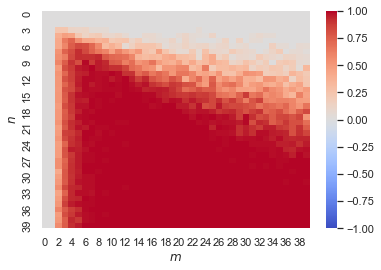

In [18]:
heatmap = sns.heatmap(scores, vmin=-1, vmax=1, cmap='coolwarm')
_ = heatmap.set(xlabel=r'$m$', ylabel=r'$n$')

As we can see, rank optimal assignment is always better or equal in performance.

In [19]:
def iterate_rank_maximal_allocation(ranks):
    (n, m) = ranks.shape
    
    
    overall_jobs = {i:[] for i in range(n)}
    
    while (True):
        applicants_rm, jobs_rm = rank_maximal_allocation(ranks)
        for i in range(n):
            applicant = applicants_rm[i]
            selected_job = jobs_rm[i]
            
            
            overall_jobs[applicant].append(jobs_rm[i])
            
        break
        
        
    return overall_jobs

In [20]:
ranks

array([[1, 6, 5, 7, 4, 2, 0, 3],
       [4, 5, 7, 6, 0, 1, 3, 2],
       [0, 5, 1, 7, 3, 2, 6, 4]])

In [21]:
iterate_rank_maximal_allocation(ranks)

{0: [6], 1: [4], 2: [0]}